In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from data.io import Reader, Saver
from analyzer.model.regression_model import RegressionModel
from data.plot import Drawer
from analyzer.stat_criterion.stat_criteria import StatCriteria
from data.encoder import Encoder
from data.normalizer import Normalizer
from data import DataPreparation

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import kruskal, mannwhitneyu, chi2_contingency, chisquare, norm, ttest_1samp, ttest_ind, shapiro
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import backend as K


In [31]:
# читаем датасет
csv_path = Reader.get_csv_path('notebooks\dataset', 'RK_554B_data.csv')
df_original = Reader.read_csv(csv_path)
df = df_original.copy().reset_index(drop=True)
df = df.drop('number', axis = 1)
mask = df['resistor'] != 6000
df = df[mask]
df.head(10)

,freq,r,c0,cq,q1000,tmax,rc/rb,resistor
0,0.6,72.8,2.90,0.18,1211,86.5,1.34,7549
1,-0.7,67.1,2.89,0.19,1229,84.9,1.36,8100
2,0.5,74.3,2.77,0.19,1100,78.3,1.42,10070
3,0.0,95.1,2.70,0.18,918,83.7,1.38,8196
4,-0.1,66.3,2.81,0.19,1249,87.1,1.42,6705
5,-0.5,67.5,2.89,0.19,1228,84.2,1.36,7388
6,-0.3,66.3,2.93,0.19,1238,85.9,1.42,6875
7,0.5,71.7,2.79,0.19,1135,82.5,1.40,8541
8,-1.0,79.6,2.75,0.18,1106,80.3,1.37,9266
9,-0.3,66.0,2.91,0.19,1277,81.9,1.40,8784


# Постановка задачи

найти значение compensation_resistor на основе использования поступающих входных данных

# Преобразование данных

In [32]:
# посмотрим на пропуски в данных
df.isna().sum()

freq        0
r           0
c0          0
cq          0
q1000       0
tmax        0
rc/rb       0
resistor    0
dtype: int64

In [33]:
# смотрим на типы данных и требования к памяти
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, 0 to 182
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freq      177 non-null    float64
 1   r         177 non-null    float64
 2   c0        177 non-null    float64
 3   cq        177 non-null    float64
 4   q1000     177 non-null    int64  
 5   tmax      177 non-null    float64
 6   rc/rb     177 non-null    float64
 7   resistor  177 non-null    int64  
dtypes: float64(6), int64(2)
memory usage: 12.4 KB


In [34]:
# Посмотрим статистику о датасете
df.describe()

,freq,r,c0,cq,q1000,tmax,rc/rb,resistor
count,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,-0.247458,69.216949,2.829266,0.190113,1203.768362,83.469492,1.371977,8213.615819
std,1.102635,4.455939,0.158899,0.007150,64.772570,2.791582,0.064218,1062.141485
min,-7.800000,63.100000,1.010000,0.150000,867.000000,76.500000,1.110000,5366.000000
25%,-0.600000,66.300000,2.790000,0.190000,1176.000000,81.500000,1.350000,7408.000000
50%,-0.100000,68.100000,2.840000,0.190000,1206.000000,83.700000,1.380000,8216.000000
75%,0.400000,71.200000,2.890000,0.190000,1239.000000,85.400000,1.410000,8981.000000
max,4.600000,98.100000,3.210000,0.200000,1368.000000,93.600000,1.630000,11193.000000


# Проводим визуальный анализ

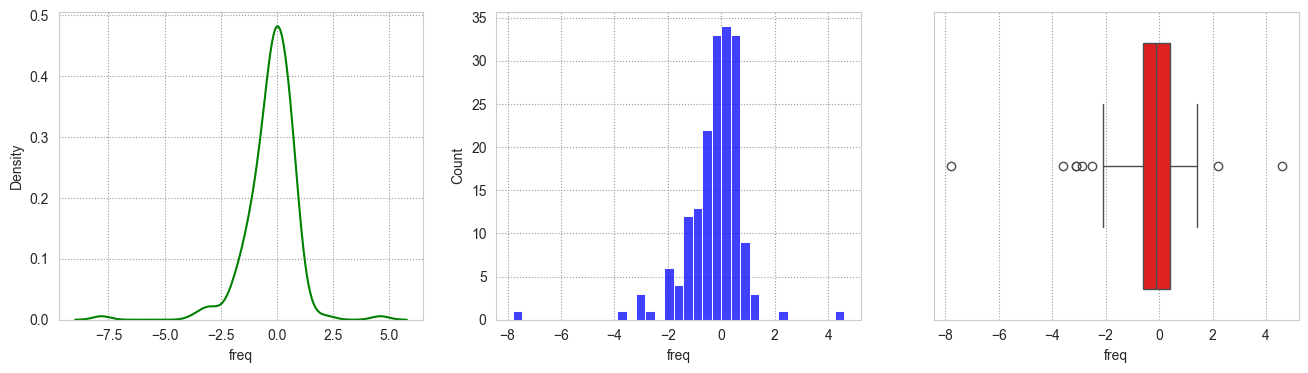

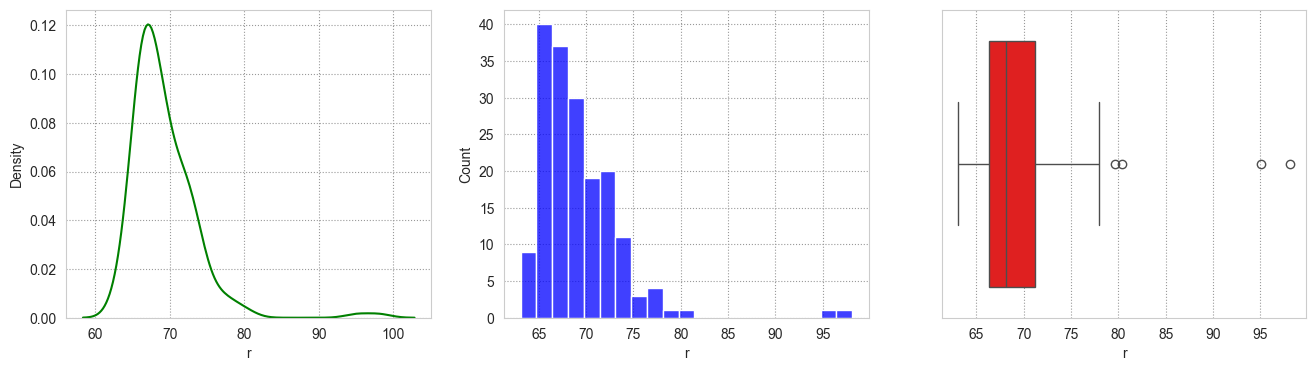

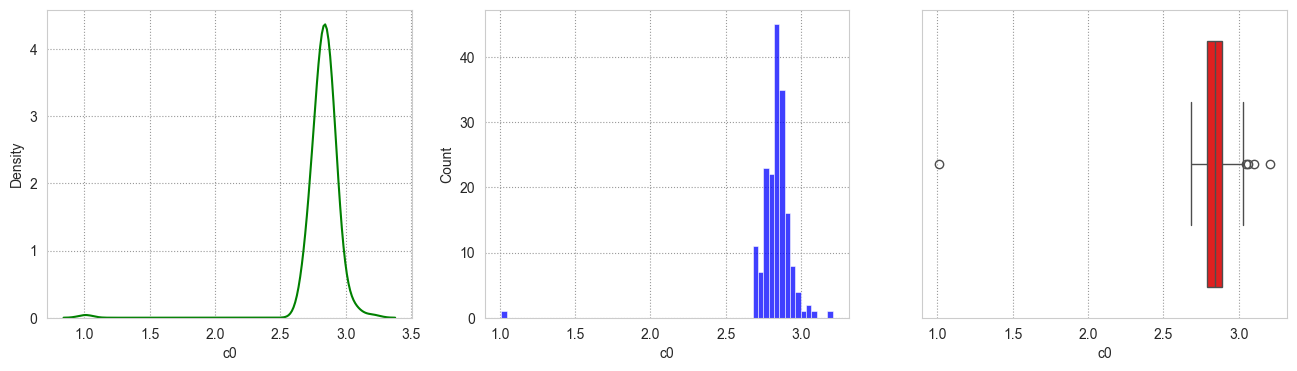

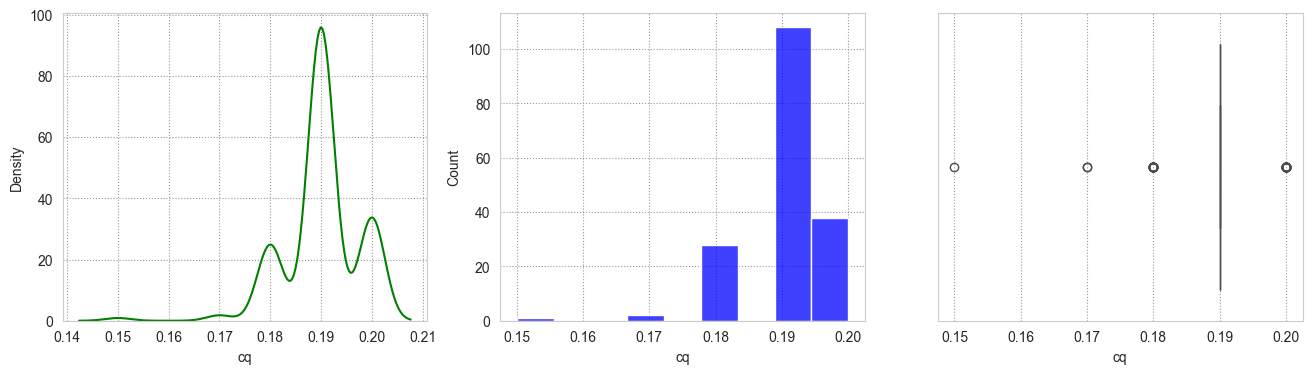

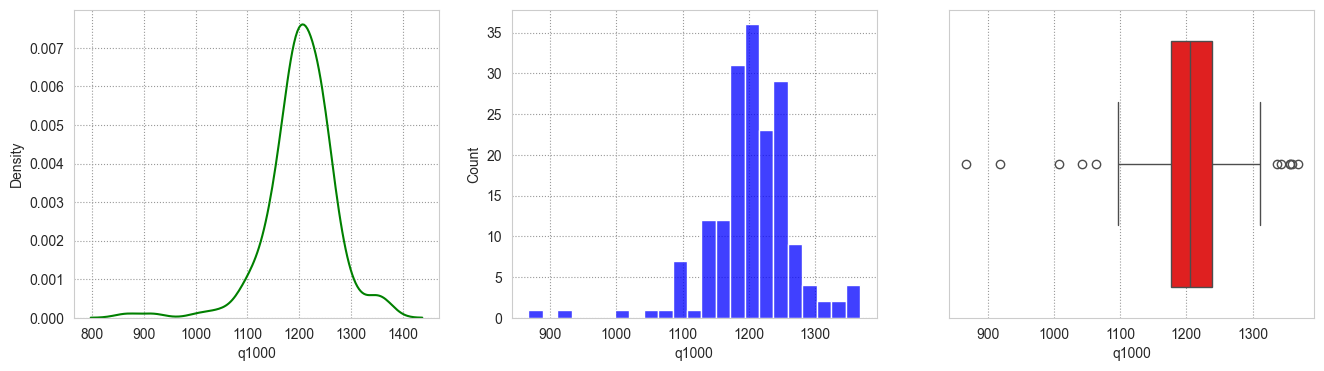

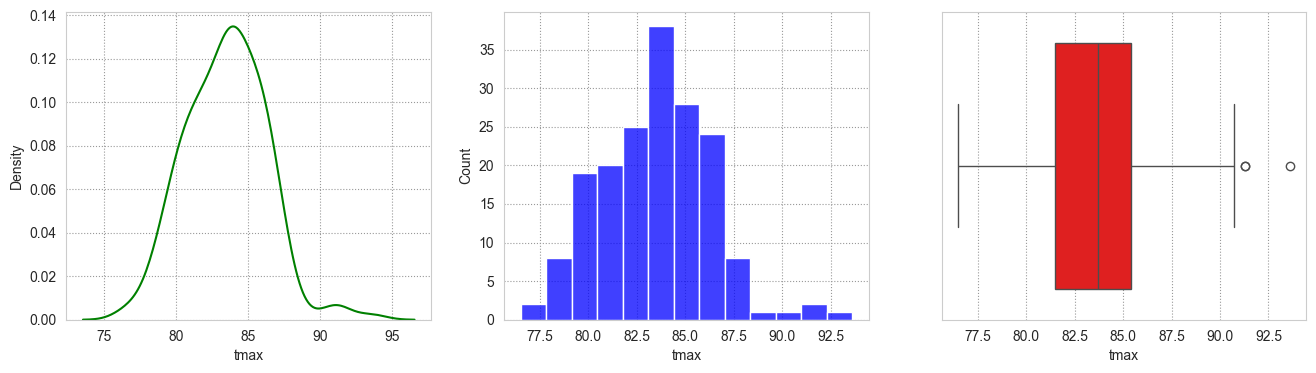

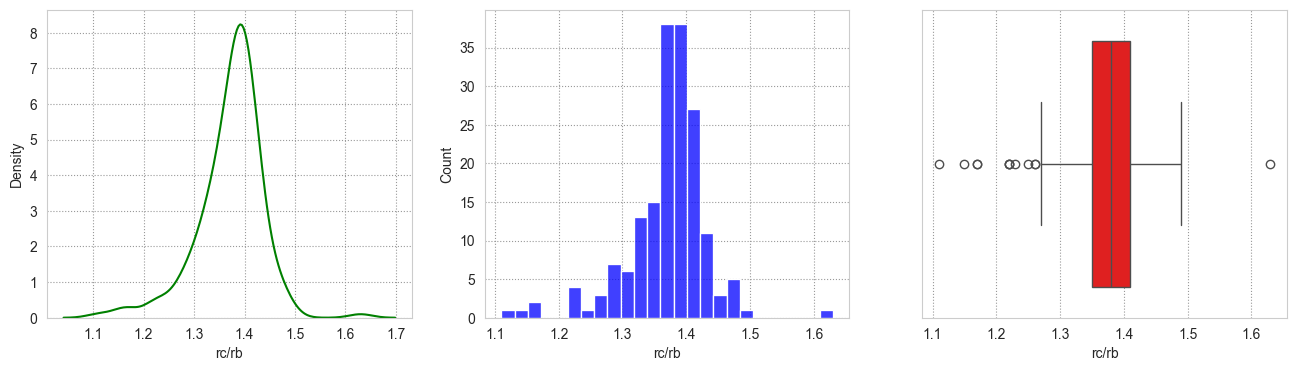

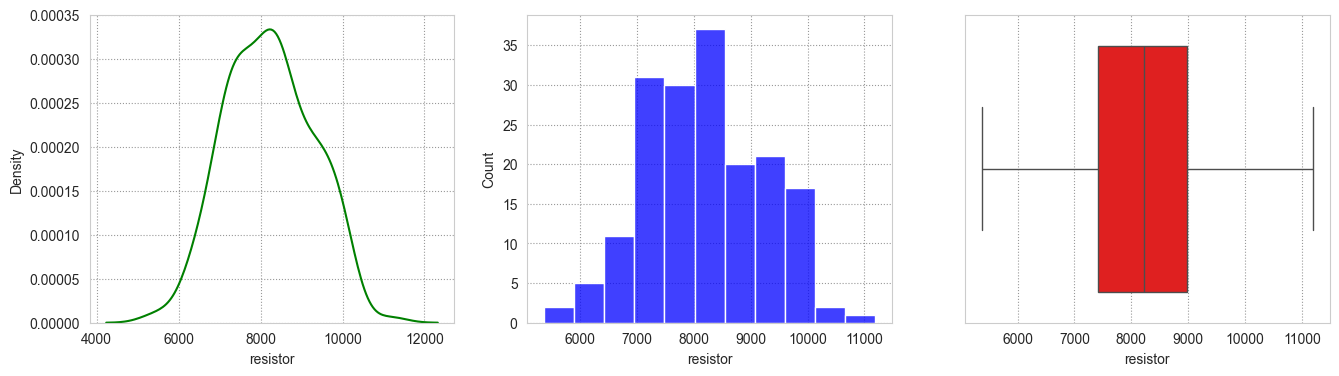

In [35]:
# Посмотрим на виды распределений "числовых" параметров и на ящики с усами
Drawer.plot_numeric_seaborn(df)

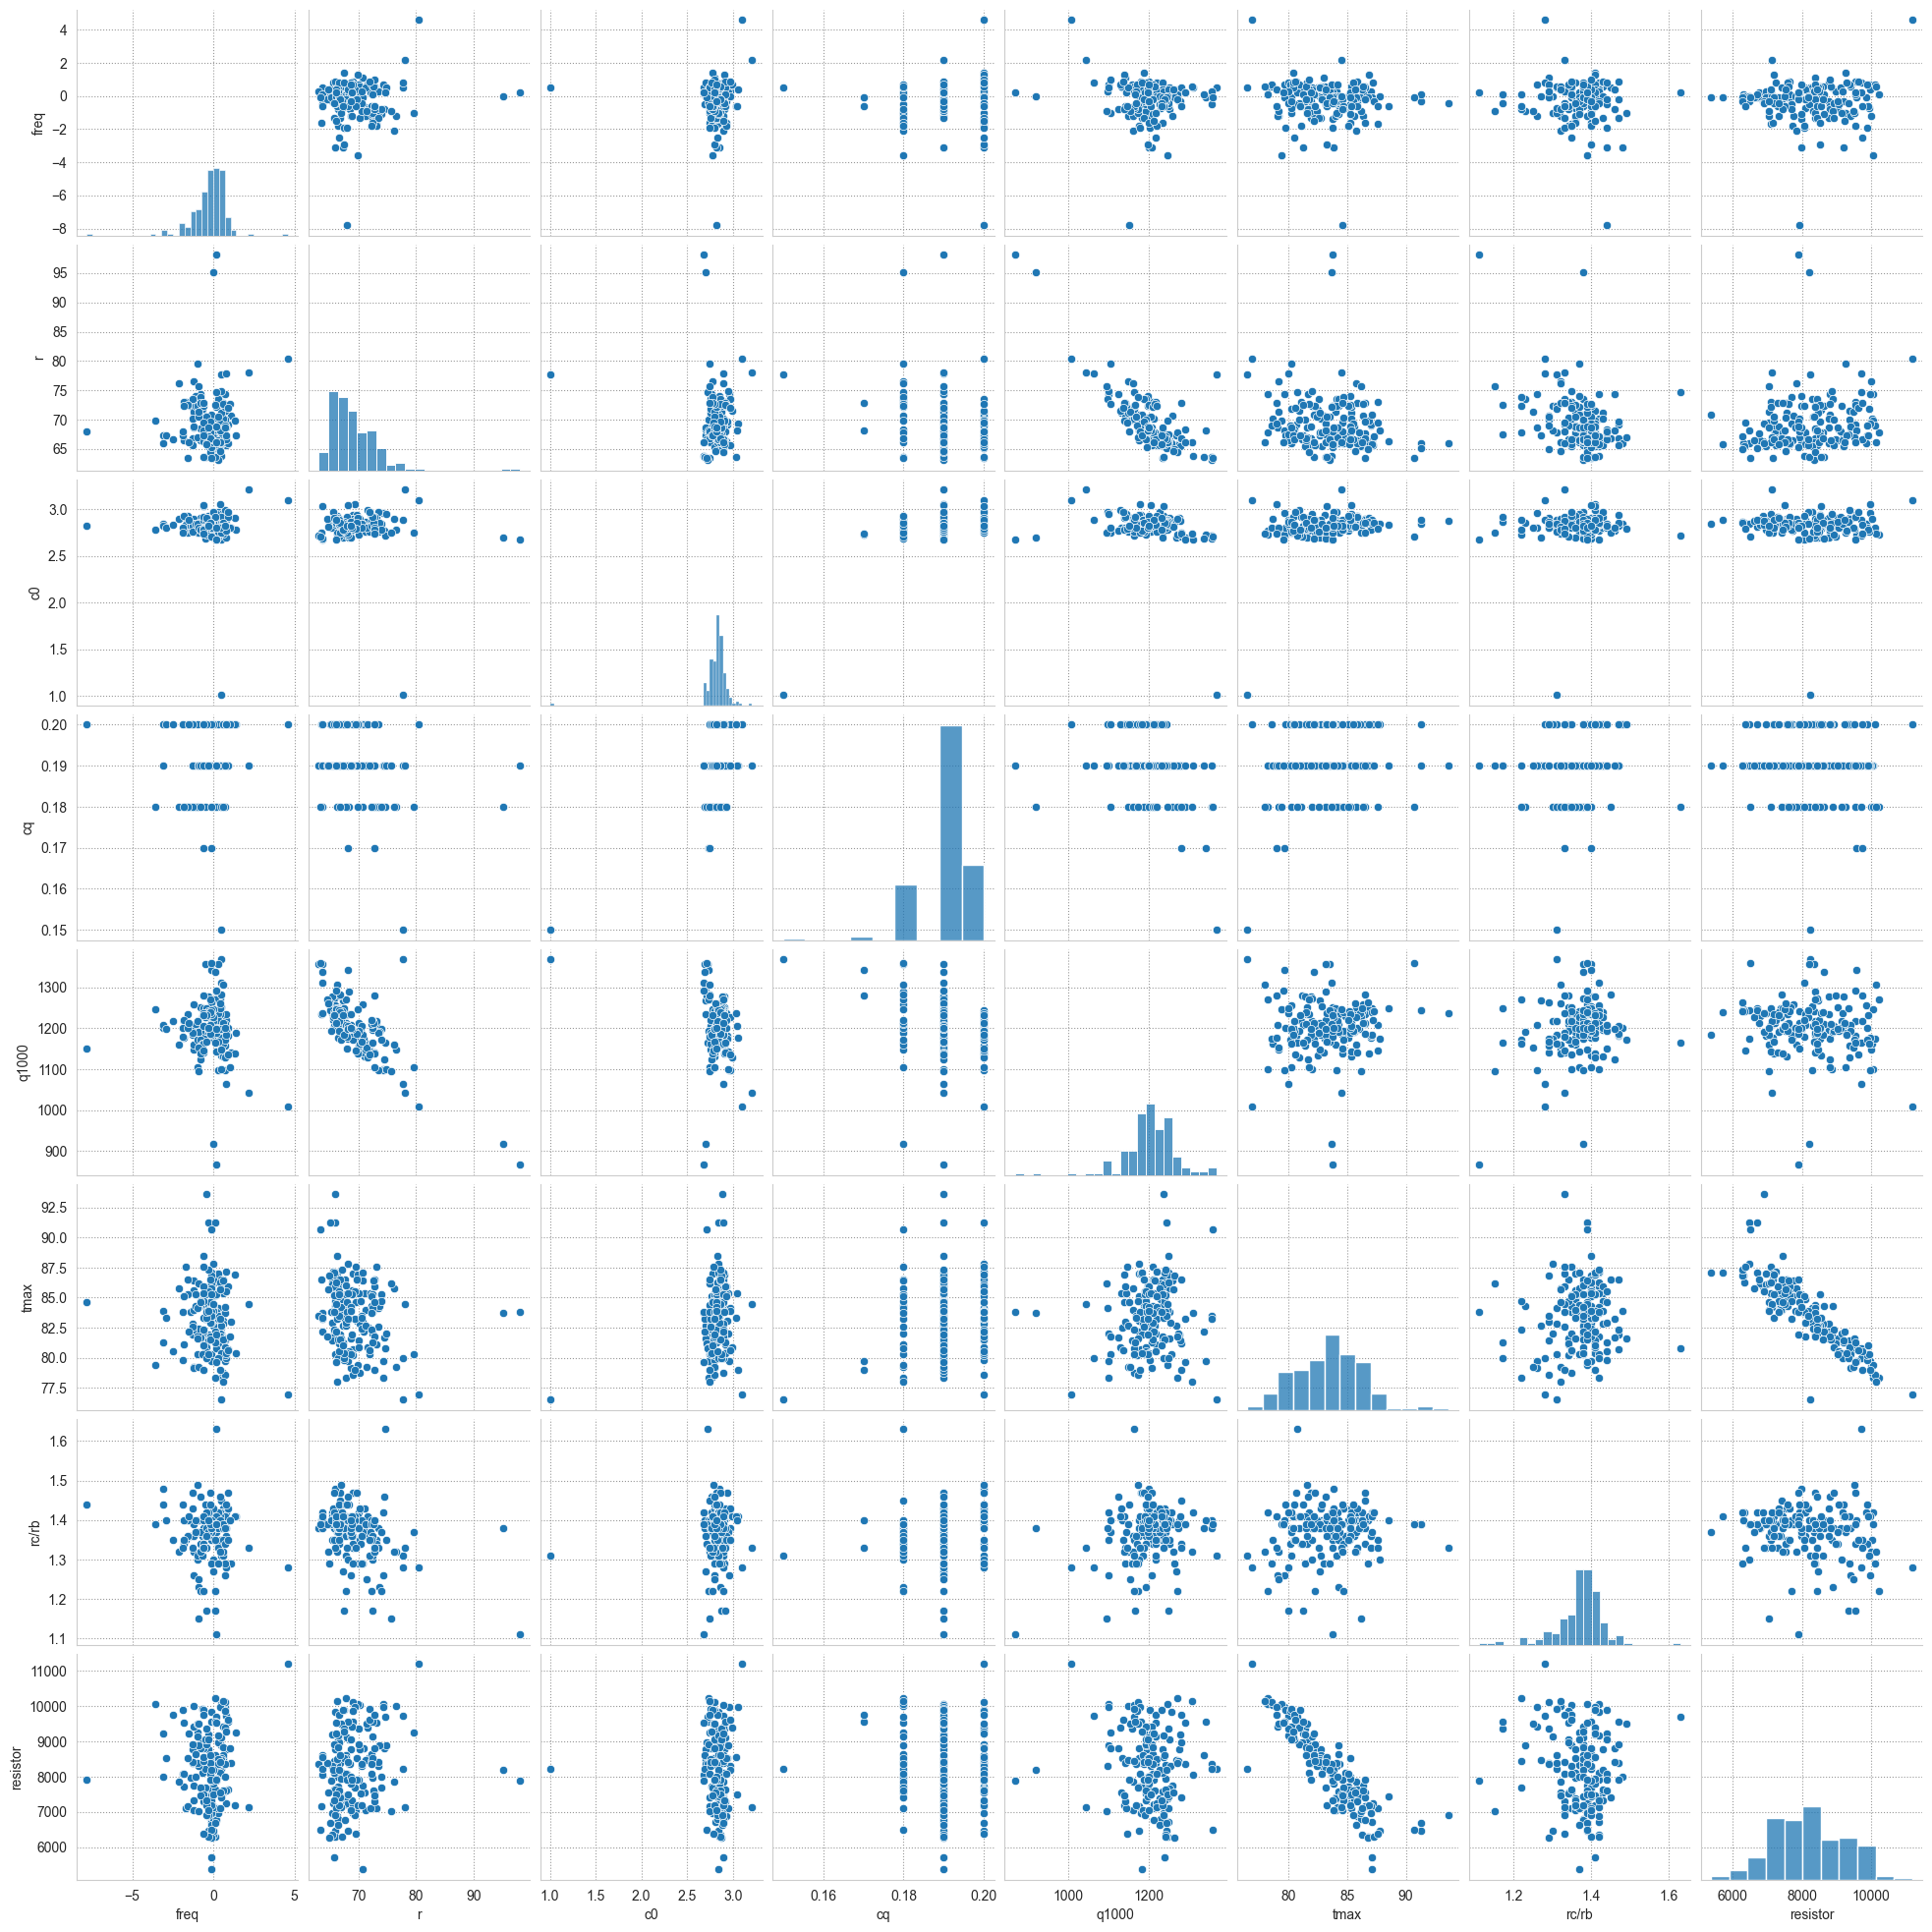

In [36]:
# Исследуем графически зависимость признаков на целевую переменную для обычной недвижимости
numeric_col = df.describe().columns
sns.pairplot(df[numeric_col])

# Анализ зависимости признаков

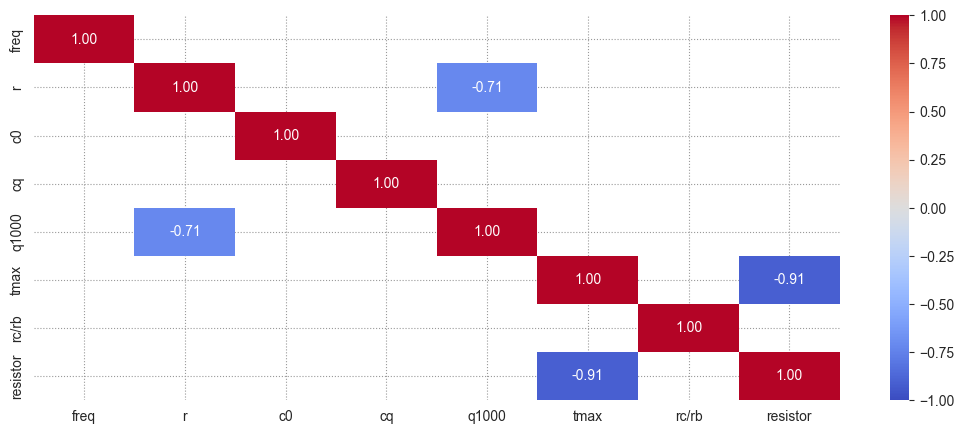

In [37]:
# Исследуем тепловую карту корреляции признаков на целевую переменную для обычной недвижимости
Drawer.plot_heatmap(df, method='spearman')

In [38]:
df.columns

Index(['freq', 'r', 'c0', 'cq', 'q1000', 'tmax', 'rc/rb', 'resistor'], dtype='object')

In [39]:
# Проверим допущение о мультиколлинеарности
columns_list = ['resistor', 'freq', 'r', 'c0', 'cq', 'q1000']
numeric_col = df.drop(columns=columns_list).describe().columns
vif_data = pd.DataFrame()
vif_data.index = numeric_col

vif_data['VIF'] = [variance_inflation_factor(df[numeric_col].values, i) for i in range(len(numeric_col))]
vif_data

,VIF
tmax,341.982268
rc/rb,341.982268


In [40]:
df.head()

,freq,r,c0,cq,q1000,tmax,rc/rb,resistor
0,0.6,72.8,2.90,0.18,1211,86.5,1.34,7549
1,-0.7,67.1,2.89,0.19,1229,84.9,1.36,8100
2,0.5,74.3,2.77,0.19,1100,78.3,1.42,10070
3,0.0,95.1,2.70,0.18,918,83.7,1.38,8196
4,-0.1,66.3,2.81,0.19,1249,87.1,1.42,6705


In [41]:
groups = [df['tmax'], df['resistor']]
stat, p_value = mannwhitneyu(*groups, alternative='two-sided')
print(p_value)

1.5850353815305625e-59


# Подготавливаем данные

In [42]:
df.columns

Index(['freq', 'r', 'c0', 'cq', 'q1000', 'tmax', 'rc/rb', 'resistor'], dtype='object')

In [43]:
# подготавливаем данные
target = ['resistor']
# exclude_features = ['resistor', 'q1000']
exclude_features = ['resistor', 'freq', 'r', 'c0', 'cq', 'q1000', 'rc/rb']

X_train, X_test, y_train, y_test = DataPreparation().train_test_split(df, exclude_features, target)

# проводим нормализацию
X_train, X_test, _ = Normalizer().MinMaxScaler(X_train, X_test)
y_train, y_test, scaler_y = Normalizer().MinMaxScaler(y_train, y_test)
X_train, X_test, y_train, y_test = Normalizer().reset_index(X_train, X_test, y_train, y_test)

# Создаём модель

In [44]:
# Применим метод OLS
y_test, y_pred, _ = RegressionModel().OLS(X_train, X_test, y_train, y_test)

                            OLS Regression Results                            
Dep. Variable:                   tmax   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.030e+32
Date:                Fri, 07 Feb 2025   Prob (F-statistic):               0.00
Time:                        14:04:23   Log-Likelihood:                 4687.7
No. Observations:                 132   AIC:                            -9371.
Df Residuals:                     130   BIC:                            -9366.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
tmax           1.0000   4.98e-17   2.01e+16      0.0

In [45]:
# Применим метод Lasso
y_test, y_pred, _ = RegressionModel().Lasso(X_train, X_test, y_train, y_test)

R²: 0.819
MAE: 0.06
MAPE: 26%
RMSE: 0
MSE: 0
__________
Коэффициенты Lasso-регрессии:
tmax: 0.61


In [46]:
# Применим метод опорных векторов
y_test, y_pred, _ = RegressionModel().SVR(X_train, X_test, y_train, y_test, kernel='rbf', C=1.0, epsilon=0.01)

R²: 0.996
MAE: 0.01
MAPE: 6%
RMSE: 0
MSE: 0


C:\Users\Tikhon\Documents\PycharmProjects\PDA120_practice2\venv\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
# Определение метрик
def r2_score(y_test_, y_pred_):
    y_test_ = K.cast(y_test_, dtype='float64')  # Приведение к float32
    y_pred_ = K.cast(y_pred_, dtype='float64')  # Приведение к float32
    SS_res = K.sum(K.square(y_test_ - y_pred_))
    SS_tot = K.sum(K.square(y_test_ - K.mean(y_test_)))
    return 1 - SS_res / (SS_tot + K.epsilon())

def mape(y_test_, y_pred_):
    y_test_ = K.cast(y_test_, dtype='float64')  # Приведение к float32
    y_pred_ = K.cast(y_pred_, dtype='float64')  # Приведение к float32
    return K.mean(K.abs((y_test_ - y_pred_) / y_test_)) * 100

# Создание модели
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))  # Линейная активация для регрессии

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_score, mape])

# Обучение модели
epochs = 15
history = model.fit(X_train, y_train, epochs=epochs, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0215 - mape: inf - r2_score: -0.1714 - val_loss: 0.0036 - val_mape: 24.3572 - val_r2_score: 0.8078
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mape: inf - r2_score: 0.8228 - val_loss: 0.0021 - val_mape: 12.4049 - val_r2_score: 0.9005
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6463e-04 - mape: inf - r2_score: 0.9380 - val_loss: 3.8739e-04 - val_mape: 8.6487 - val_r2_score: 0.9853
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5413e-04 - mape: inf - r2_score: 0.9879 - val_loss: 1.9643e-04 - val_mape: 6.5240 - val_r2_score: 0.9931
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1130e-04 - mape: inf - r2_score: 0.9942 - val_loss: 1.4134e-04 - val_mape: 4.9446 - val_r2_score: 0.9947
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3114e-05 - mape: inf - r2_score: 0.9978 - val_loss: 4.8611e-05 - val_mape: 3.8020 - val_r2_score: 0.9988
Epoch 7/15
17/17 ━━━━━

<Axes: >

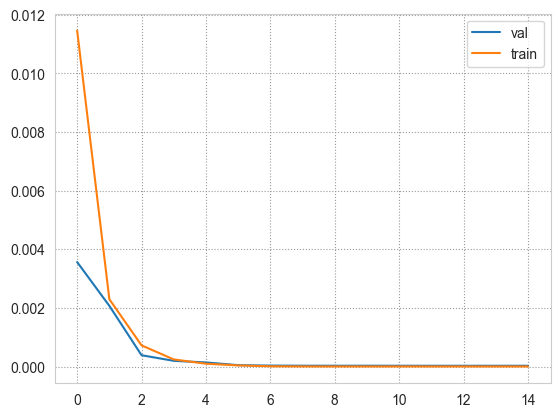

In [48]:
sns.lineplot(y=history.history['val_loss'], x=np.arange(epochs), label='val')
sns.lineplot(y=history.history['loss'], x=np.arange(epochs), label='train')
#history.history['val_loss']